In [167]:
import pandas as pd
import ee
import statsmodels.api as sm
import matplotlib.pyplot as plt
from drought.data import interpolate
from drought.data import seasonal
from drought.visualization import plot
import seaborn as sns
from drought.data import pipeline, ee_climate, ee_converter
from drought.data.vi_extract import get_monthly_vi_data, VI_COLUMNS
import spei as si
import numpy as np
import altair as alt
import importlib
importlib.reload(seasonal)
importlib.reload(plot)

<module 'drought.visualization.plot' from '/Users/jovanaknezevic/drought-with-gedi/drought/visualization/plot.py'>

In [79]:
ee.Initialize()

In [216]:
spei = pd.read_csv('../../data/interim/2001-2023_spei_per_polygon_50km_climate_resolution.csv', index_col=0)
spei = spei[spei.polygon_id==2].reset_index().sort_values('datetime')

In [217]:
monthly_gedi = pd.read_csv("../../data/interim/gedi_monthly_extended_interpolated_March_11.csv", index_col=0)
monthly_gedi = monthly_gedi[monthly_gedi.polygon_id==2].sort_values('datetime')

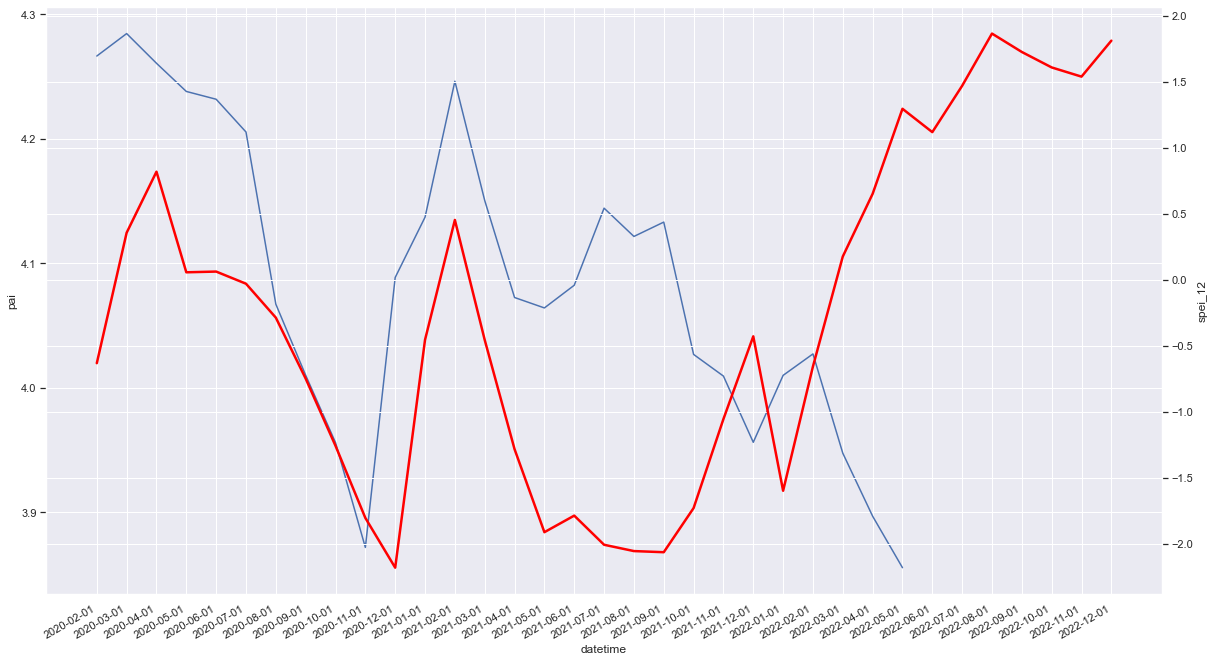

In [259]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(1, 1, figsize=(20, 12), sharex=True)
sns.lineplot(monthly_gedi[monthly_gedi.datetime > '2020-01-01'], x='datetime', y='pai', ax=ax)
sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='spei_12', color='red', linewidth=2.5, ax=ax.twinx())
fig.autofmt_xdate()

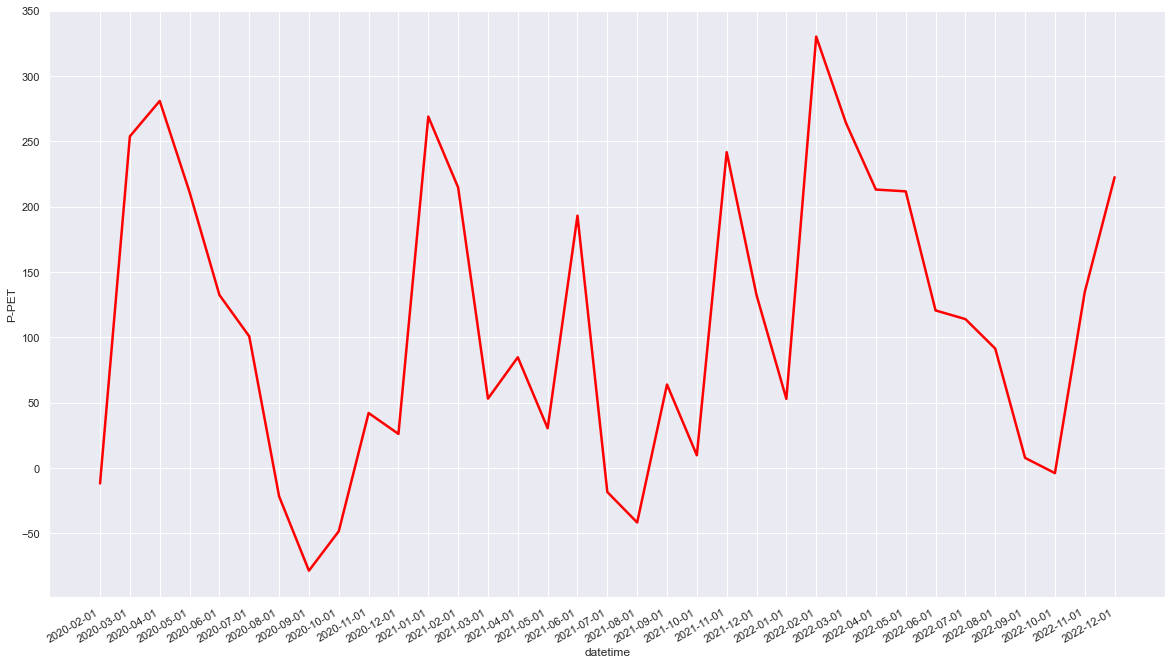

In [249]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(1, 1, figsize=(20, 12), sharex=True)
#sns.lineplot(monthly_gedi[monthly_gedi.datetime > '2020-01-01'], x='datetime', y='pai', ax=ax)
sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='P-PET', color='red', linewidth=2.5, ax=ax)
#sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='PET', color='blue', linewidth=2.5, ax=ax.twinx())
#sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='precipitation', color='green', linewidth=2.5, ax=ax.twinx())
fig.autofmt_xdate()

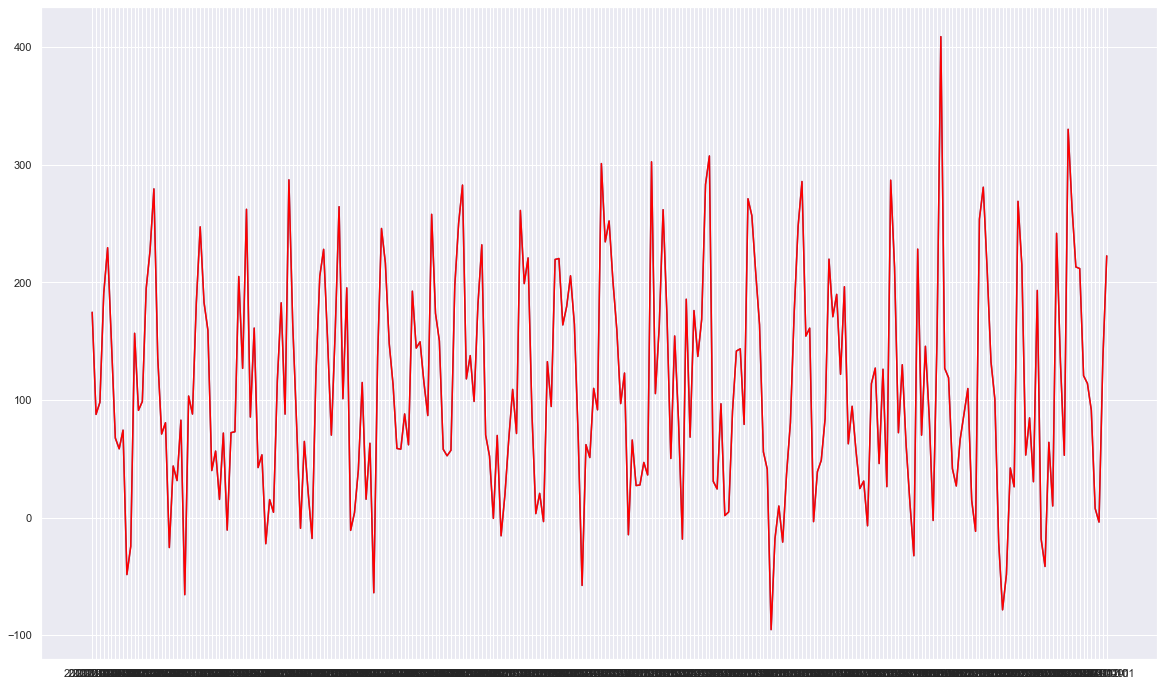

In [247]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(1, 1, figsize=(20, 12), sharex=True)
#sns.lineplot(monthly_gedi[monthly_gedi.datetime > '2020-01-01'], x='datetime', y='pai', ax=ax)
sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='P-PET', color='red', linewidth=2.5, ax=ax)
#sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='PET', color='blue', linewidth=2.5, ax=ax.twinx())
#sns.lineplot(spei[spei.datetime > '2020-01-01'], x='datetime', y='precipitation', color='green', linewidth=2.5, ax=ax.twinx())
fig.autofmt_xdate()

## Let's get high resolution data for polygon 2 in particular

#### First, climate data!

In [97]:
# Dates of interest.
start_date_str = '2001-01-01'
end_date_str = '2023-01-01'
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geom_polygon = pipeline.get_ee_polygons()[1]

# Specify resolution.
scale = 20000

In [168]:
precip_ic = ee_climate.get_monthly_precipitation_data(start_date, end_date)
pet_ic = ee_climate.get_monthly_evapotranspiration_data(start_date, end_date)
vi_ic = get_monthly_vi_data(start_date, end_date)

In [99]:
precip_df = ee_converter.get_region_as_df(precip_ic, ee_geom_polygon, scale, ['precipitation'])

In [100]:
pet_df = ee_converter.get_region_as_df(pet_ic, ee_geom_polygon, scale, ['PET'])

In [170]:
vi_pdf = ee_converter.get_region_as_df(vi_ic, ee_geom_polygon, scale, VI_COLUMNS)

In [174]:
index = ['datetime', 'month', 'year', 'longitude', 'latitude']
#precip_df = precip_df.drop(columns=['time'])
#pet_df = pet_df.drop(columns=['time'])
vi_pdf = vi_pdf.drop(columns=['time'])
data = precip_df.set_index(index).join(pet_df.set_index(index))
data = data.join(vi_pdf.set_index(index)).reset_index()

In [175]:
data

0       datetime  month  year  longitude  latitude  precipitation         PET  \
0     2001-01-01      1  2001 -67.822804 -1.167810     398.395500         NaN   
1     2001-01-01      1  2001 -66.385499  0.269495     306.595342  184.534233   
2     2001-01-01      1  2001 -66.385499 -0.988147     298.642590  140.275003   
3     2001-01-01      1  2001 -66.205836 -0.988147     286.728080  114.700001   
4     2001-01-01      1  2001 -66.565163  0.269495     311.141406  128.346739   
...          ...    ...   ...        ...       ...            ...         ...   
26395 2022-12-01     12  2022 -66.385499 -0.089832     275.787114  145.404762   
26396 2022-12-01     12  2022 -68.002467  0.089832     456.402617  141.101666   
26397 2022-12-01     12  2022 -67.822804  0.089832     499.493587  137.691665   
26398 2022-12-01     12  2022 -67.463478  0.089832     429.432979  114.506251   
26399 2022-12-01     12  2022 -66.385499  0.449158     340.050926  140.145833   

0          ndvi       evi  
0      0.806279  1.995662  
1      0.826373  2.318069  
2      0.833978  2.108035  
3      0.825213  2.061291  
4      0.822822  2.163498  
...         ...       ...  
26395  0.824542  2.221897  
26396  0.791679  2.046740  
26397  0.830350  2.155748  
26398  0.808111  2.203024  
26399  0.838413  2.286355  

[26400 rows x 9 columns]

In [176]:
data['P-PET'] = data.precipitation - data.PET

In [177]:
data.to_csv("../../data/interim/polygon_2_water_data_and_VEG_data_2001-2023_20km_res.csv")

### Try to calculate SPEI for each 5kmx5km region

In [116]:
def calculate_spei(group):
    print((group.latitude.iloc[0], group.longitude.iloc[0]))
    print(group.PET.isna().sum())
    PERIODS = [1, 3, 6, 9, 12, 18]
    group = group.sort_index()
    for period in PERIODS:
        if group.PET.isna().sum() > 60:
            group[f'spei_{period}'] = np.nan
        else:
            rolling_sum = (group['P-PET'].sort_index()).interpolate().rolling(period).sum().dropna()
            group[f'spei_{period}'] = si.si.spei(rolling_sum)
    return group

In [117]:
data_with_spei = data.set_index('datetime').groupby(['longitude', 'latitude']).apply(calculate_spei)

(-0.8084837557075694, -68.00246700784777)
48
(-0.628820698883665, -68.00246700784777)
54
(-0.4491576420597607, -68.00246700784777)
46
(-0.26949458523585645, -68.00246700784777)
44
(-0.08983152841195215, -68.00246700784777)
54
(0.08983152841195215, -68.00246700784777)
5
(0.26949458523585645, -68.00246700784777)
57
(0.4491576420597607, -68.00246700784777)
51
(-1.167809869355378, -67.82280395102387)
46
(-0.9881468125314736, -67.82280395102387)
41
(-0.8084837557075694, -67.82280395102387)
52
(-0.628820698883665, -67.82280395102387)
51
(-0.4491576420597607, -67.82280395102387)
66
(-0.26949458523585645, -67.82280395102387)
38
(-0.08983152841195215, -67.82280395102387)
56
(0.08983152841195215, -67.82280395102387)
2
(0.26949458523585645, -67.82280395102387)
44
(0.4491576420597607, -67.82280395102387)
54
(-1.167809869355378, -67.64314089419997)
26
(-0.9881468125314736, -67.64314089419997)
44
(-0.8084837557075694, -67.64314089419997)
49
(-0.628820698883665, -67.64314089419997)
17
(-0.44915764205

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_7121/1124300342.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_with_spei = grouped.apply(calculate_spei)


In [119]:
data_with_spei.to_csv("../../data/interim/polygon_2_spei_2001-2022_20km.csv")

In [151]:
datas = data_with_spei.round(2)

In [148]:
data_with_spei[data_with_spei.index == '2020-12-01']

0           month  year  longitude  latitude  precipitation         PET  \
datetime                                                                  
2020-12-01     12  2020 -68.002467 -0.808484     225.464599  135.366671   
2020-12-01     12  2020 -68.002467 -0.628821     252.466804  126.435711   
2020-12-01     12  2020 -68.002467 -0.449158     264.731695  139.887494   
2020-12-01     12  2020 -68.002467 -0.269495     237.617762  146.474997   
2020-12-01     12  2020 -68.002467 -0.089832     233.473157  129.535719   
...           ...   ...        ...       ...            ...         ...   
2020-12-01     12  2020 -66.385499  0.089832     122.993295   99.716663   
2020-12-01     12  2020 -66.385499  0.269495     139.283512  116.250000   
2020-12-01     12  2020 -66.385499  0.449158     139.403411  126.712503   
2020-12-01     12  2020 -66.205836 -1.167810     203.372882         NaN   
2020-12-01     12  2020 -66.205836 -0.988147     200.077581  162.362506   

0                P-PET    spei_1    spei_3    spei_6    spei_9   spei_12  \
datetime                                                                   
2020-12-01   90.097929 -0.717485 -0.438262 -0.873053 -0.237727 -0.108746   
2020-12-01  126.031093  0.200657  0.182156 -0.003044  0.379611 -0.008576   
2020-12-01  124.844201 -0.050036 -0.085333 -0.790618 -0.654875 -0.549653   
2020-12-01   91.142765 -0.821948 -0.889921 -1.261866 -1.141810 -1.229828   
2020-12-01  103.937439 -0.597416 -0.971494 -1.662817 -1.617496 -1.728717   
...                ...       ...       ...       ...       ...       ...   
2020-12-01   23.276632 -0.444419 -0.878884 -1.663641 -2.090826 -2.301563   
2020-12-01   23.033512 -0.439101 -2.009023 -2.188357 -1.574958 -2.338136   
2020-12-01   12.690908 -0.738904 -1.539611 -2.331790 -2.428161 -2.842025   
2020-12-01         NaN  0.476929  0.080544 -0.538473 -0.360716 -1.356031   
2020-12-01   37.715075 -0.378758 -0.415358 -0.818689 -0.671386 -1.152850   

0            spei_18  
datetime              
2020-12-01  0.450770  
2020-12-01  0.719915  
2020-12-01  0.168938  
2020-12-01 -0.769829  
2020-12-01 -1.060185  
...              ...  
2020-12-01 -1.867079  
2020-12-01 -1.700802  
2020-12-01 -2.595239  
2020-12-01 -1.398950  
2020-12-01 -0.580699  

[100 rows x 13 columns]

In [ ]:
data[data['P-PET'].isna()].datetime.unique()

array(['2001-01-01T00:00:00.000000000', '2001-02-01T00:00:00.000000000',
       '2001-03-01T00:00:00.000000000', '2001-04-01T00:00:00.000000000',
       '2001-05-01T00:00:00.000000000', '2001-06-01T00:00:00.000000000',
       '2001-07-01T00:00:00.000000000', '2001-08-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2002-06-01T00:00:00.000000000',
       '2002-07-01T00:00:00.000000000', '2002-08-01T00:00:00.000000000',
       '2002-09-01T00:00:00.000000000', '2002-10-01T00:00:00.000000000',
       '2002-11-01T00:00:00.000000000', '2002-12-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2003-02-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', '2003-04-01

### Visualize spei across the polygon 2

polygon_data = total_yearly_means[total_yearly_means.polygon_id==polygon_id]
    min = polygon_data['P-PET'].min()
    max = polygon_data['P-PET'].max()
    chart = alt.Chart(total_yearly_means[total_yearly_means.polygon_id==polygon_id]).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(P-PET):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(P-PET):Q', title='PDSI')
        ]).properties(width=300, height=300)
    chart.display()

In [261]:
for year in range(2019, 2023):
    print((year))
    polygon_data = datas[datas.year == year]
    print(polygon_data.spei_12.mean())
    min = polygon_data['spei_12'].min()
    max = polygon_data['spei_12'].max()
    chart = alt.Chart(polygon_data).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(spei_12):Q', scale=alt.Scale(scheme='redblue', domain=(-3, 3))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(spei_12):Q', title='PDSI')
        ]).properties(width=400, height=400)
    chart.display()

2019
-0.04963157894736842


alt.Chart(...)

2020
-0.4485350877192983


alt.Chart(...)

2021
-0.8644649122807018


alt.Chart(...)

2022
0.6309561403508772


alt.Chart(...)

In [255]:
for year in range(2020, 2022):
    for month in range(1, 13):
        print((year, month))
        polygon_data = datas[datas.index == f'{year}-{month}-01']
        print(polygon_data.spei_12.mean())
        min = polygon_data['spei_12'].min()
        max = polygon_data['spei_12'].max()
        chart = alt.Chart(polygon_data).mark_rect().encode(
            x='longitude:O',
            y= alt.Y('latitude:O', sort="descending"),
            color=alt.Color(
                'mean(spei_12):Q', scale=alt.Scale(scheme='redblue', domain=(-3, 3))),
            tooltip=[
                alt.Tooltip('longitude:O', title='Year'),
                alt.Tooltip('latitude:O', title='Month'),
                alt.Tooltip('mean(spei_12):Q', title='PDSI')
            ]).properties(width=400, height=400)
        chart.display()

(2020, 1)
-0.17568421052631578


alt.Chart(...)

(2020, 2)
-0.5527368421052633


alt.Chart(...)

(2020, 3)
0.16968421052631577


alt.Chart(...)

(2020, 4)
0.4578947368421052


alt.Chart(...)

(2020, 5)
0.016105263157894747


alt.Chart(...)

(2020, 6)
-0.07031578947368422


alt.Chart(...)

(2020, 7)
-0.13157894736842105


alt.Chart(...)

(2020, 8)
-0.31894736842105265


alt.Chart(...)

(2020, 9)
-0.7441052631578948


alt.Chart(...)

(2020, 10)
-1.089263157894737


alt.Chart(...)

(2020, 11)
-1.387578947368421


alt.Chart(...)

(2020, 12)
-1.5558947368421057


alt.Chart(...)

(2021, 1)
-0.6381052631578947


alt.Chart(...)

(2021, 2)
0.08884210526315788


alt.Chart(...)

(2021, 3)
-0.3695789473684211


alt.Chart(...)

(2021, 4)
-0.8685263157894737


alt.Chart(...)

(2021, 5)
-1.2734736842105263


alt.Chart(...)

(2021, 6)
-1.2589473684210528


alt.Chart(...)

(2021, 7)
-1.4848421052631582


alt.Chart(...)

(2021, 8)
-1.4998947368421052


alt.Chart(...)

(2021, 9)
-1.1334736842105264


alt.Chart(...)

(2021, 10)
-0.953578947368421


alt.Chart(...)

(2021, 11)
-0.5998947368421054


alt.Chart(...)

(2021, 12)
-0.3821052631578947


alt.Chart(...)

In [186]:
polygon_data = data[data.datetime == '2021-02-01']
min = polygon_data['ndvi'].min()
max = polygon_data['ndvi'].max()
chart = alt.Chart(polygon_data).mark_rect().encode(
    x='longitude:O',
    y= alt.Y('latitude:O', sort="descending"),
    color=alt.Color(
        'mean(ndvi):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
    tooltip=[
        alt.Tooltip('longitude:O', title='Year'),
        alt.Tooltip('latitude:O', title='Month'),
        alt.Tooltip('mean(ndvi):Q', title='PDSI')
    ]).properties(width=400, height=400)
chart.display()

alt.Chart(...)

In [181]:
data[data.index == '2021-08-01']

Empty DataFrame
Columns: [datetime, month, year, longitude, latitude, precipitation, PET, ndvi, evi, P-PET]
Index: []

In [200]:
monthly_gedi.datetime

1      2019-04-01
9      2019-05-01
17     2019-06-01
25     2019-07-01
33     2019-08-01
41     2019-09-01
49     2019-10-01
57     2019-11-01
65     2019-12-01
73     2020-01-01
81     2020-02-01
89     2020-03-01
97     2020-04-01
104    2020-05-01
112    2020-06-01
119    2020-07-01
126    2020-08-01
133    2020-09-01
140    2020-10-01
147    2020-11-01
155    2020-12-01
163    2021-01-01
171    2021-02-01
179    2021-03-01
186    2021-04-01
193    2021-05-01
201    2021-06-01
209    2021-07-01
217    2021-08-01
225    2021-09-01
232    2021-10-01
240    2021-11-01
248    2021-12-01
255    2022-01-01
263    2022-02-01
271    2022-03-01
278    2022-04-01
286    2022-05-01
307    2022-06-01
Name: datetime, dtype: object

In [204]:
monthly_gedi.datetime = pd.to_datetime(monthly_gedi.datetime)

### NDVI vs. PAI

<AxesSubplot: xlabel='datetime', ylabel='ndvi'>

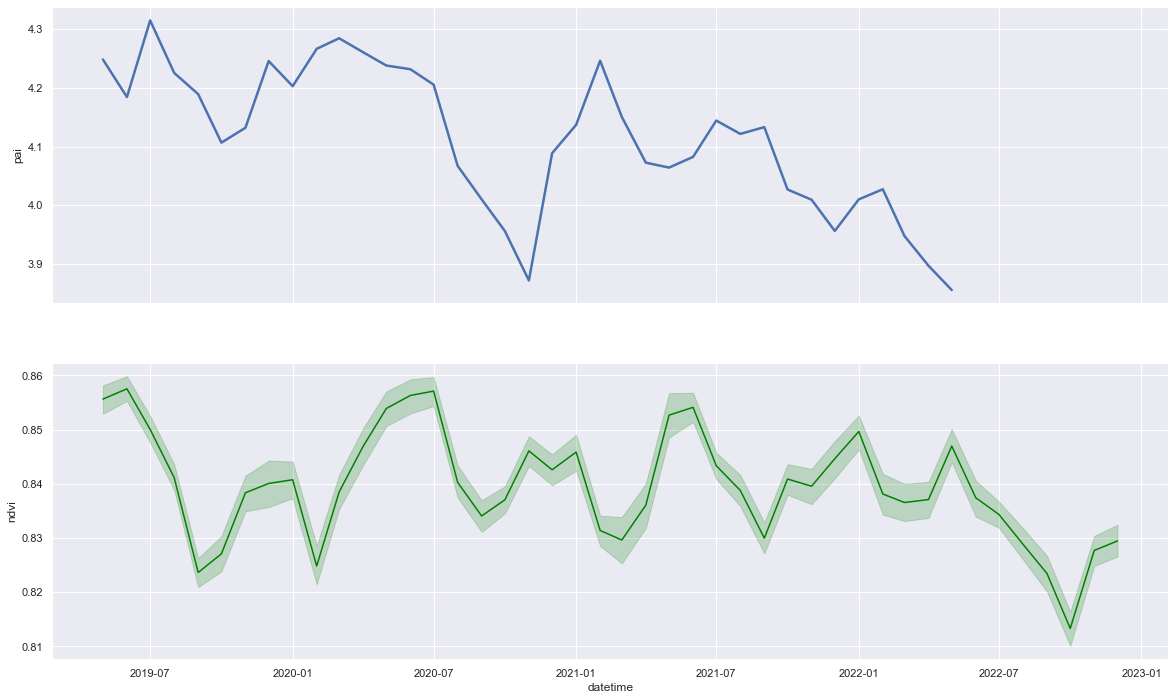

In [210]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
sns.lineplot(monthly_gedi, x='datetime', y='pai', ax=ax[0], linewidth=2.5)
sns.lineplot(data[data.datetime > monthly_gedi.datetime.min()], x='datetime', y='ndvi', ax=ax[1], color='green')
#sns.lineplot(spei[spei.datetime > monthly_gedi.datetime.min()], x='datetime', y='spei_12', color='red', linewidth=2.5, ax=ax.twinx())
#fig.autofmt_xdate()

<AxesSubplot: xlabel='datetime', ylabel='evi'>

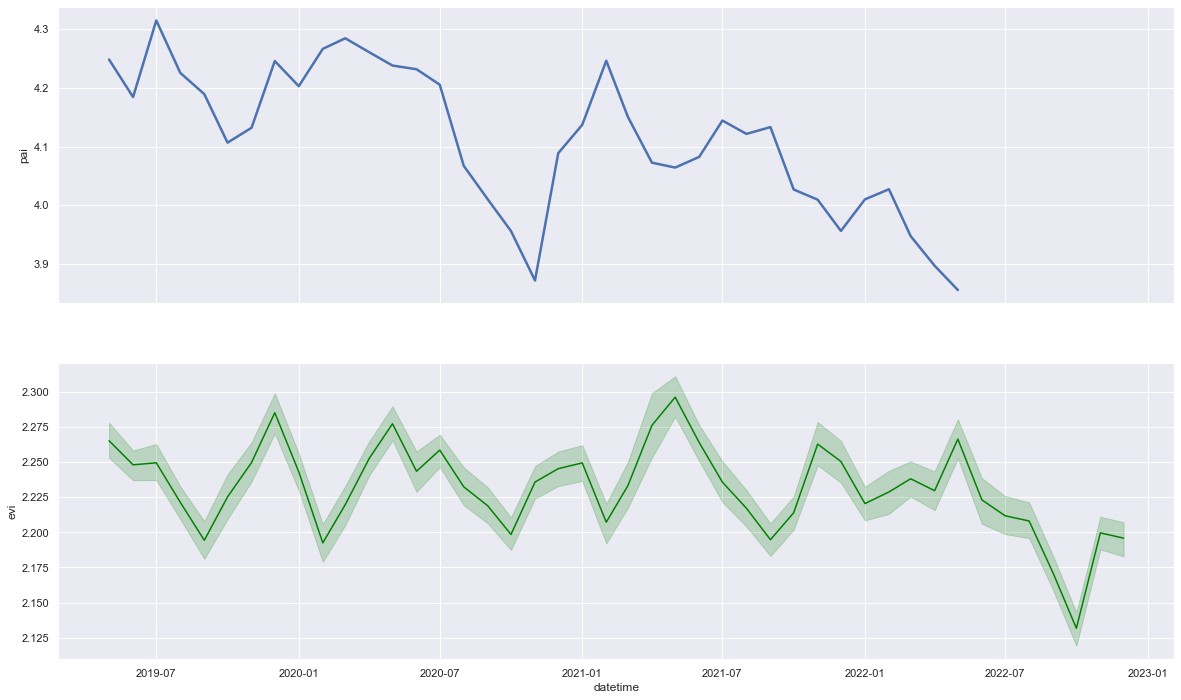

In [211]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
sns.lineplot(monthly_gedi, x='datetime', y='pai', ax=ax[0], linewidth=2.5)
sns.lineplot(data[data.datetime > monthly_gedi.datetime.min()], x='datetime', y='evi', ax=ax[1], color='green')
#sns.lineplot(spei[spei.datetime > monthly_gedi.datetime.min()], x='datetime', y='spei_12', color='red', linewidth=2.5, ax=ax.twinx())
#fig.autofmt_xdate()

<AxesSubplot: xlabel='month', ylabel='evi'>

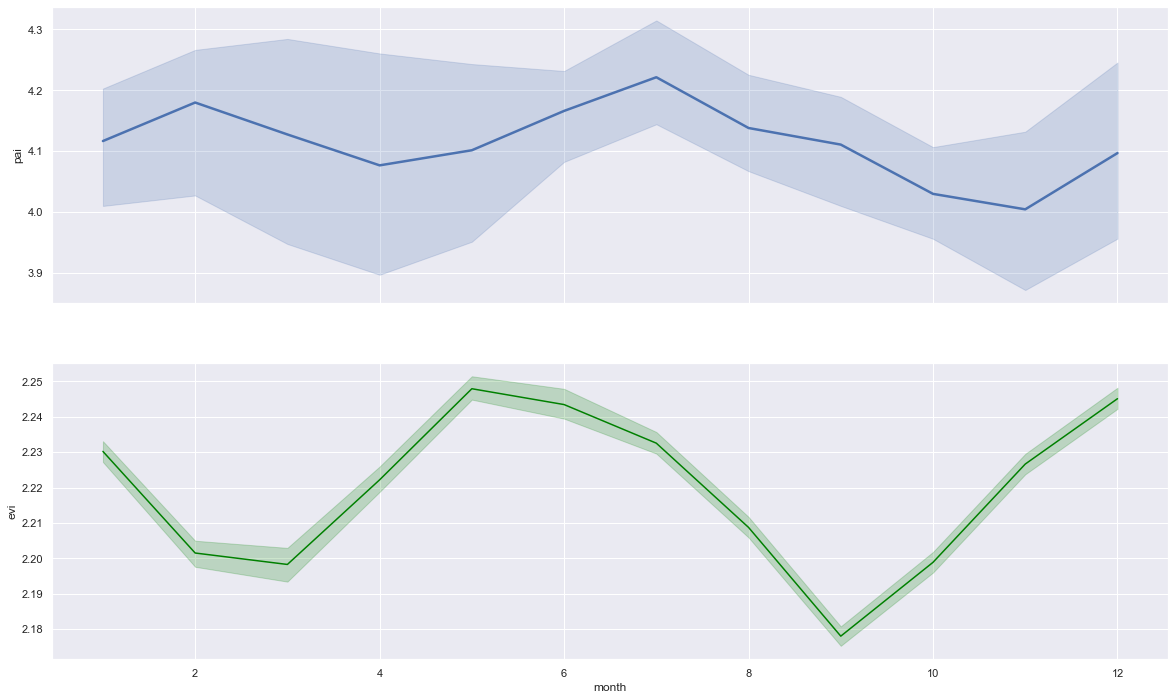

In [214]:
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
sns.lineplot(monthly_gedi, x='month', y='pai', ax=ax[0], linewidth=2.5)
sns.lineplot(data, x='month', y='evi', ax=ax[1], color='green')
#sns.lineplot(spei[spei.datetime > monthly_gedi.datetime.min()], x='datetime', y='spei_12', color='red', linewidth=2.5, ax=ax.twinx())
#fig.autofmt_xdate()

### 6 Month SPEI Analysis

In [269]:
def chart_spei_data(df, year, month_range, column):
    polygon_data = datas[(datas.year == year) & (datas.month.isin(month_range))]
    print(polygon_data.spei_12.mean())
    chart = alt.Chart(polygon_data).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            f'mean({column}):Q', scale=alt.Scale(scheme='redblue', domain=(-3, 3))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip(f'mean({column}):Q', title='PDSI')
        ]).properties(width=400, height=400)
    chart.display()

In [270]:
chart_spei_data(datas, 2020, range(1,7), 'spei_12')

-0.025842105263157878


alt.Chart(...)

In [271]:
chart_spei_data(datas, 2020, range(7, 13), 'spei_12')

-0.8712280701754387


alt.Chart(...)

In [272]:
chart_spei_data(datas, 2021, range(1,7), 'spei_12')

-0.7199649122807017


alt.Chart(...)

In [273]:
chart_spei_data(datas, 2021, range(7, 13), 'spei_12')

-1.0089649122807018


alt.Chart(...)

In [274]:
chart_spei_data(datas, 2022, range(1,7), 'spei_12')

0.01592982456140353


alt.Chart(...)

### 6 Months Precipitation Analysis

In [275]:
def chart_precipitation_data(df, year, month_range, column):
    polygon_data = datas[(datas.year == year) & (datas.month.isin(month_range))]
    print(polygon_data.precipitation.mean())

    chart = alt.Chart(polygon_data).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            f'mean({column}):Q', scale=alt.Scale(scheme='redblue', domain=(0, 450))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip(f'mean({column}):Q', title='PDSI')
        ]).properties(width=400, height=400)
    chart.display()

In [276]:
chart_precipitation_data(datas, 2020, range(1,7), 'precipitation')

296.92109999999997


alt.Chart(...)

In [277]:
chart_precipitation_data(datas, 2020, range(7, 13), 'precipitation')

170.67263333333332


alt.Chart(...)

In [282]:
chart_precipitation_data(datas, 2021, range(1, 7), 'precipitation')

278.54178333333334


alt.Chart(...)

In [279]:
chart_precipitation_data(datas, 2021, range(7, 13), 'precipitation')

219.7739


alt.Chart(...)

In [280]:
chart_precipitation_data(datas, 2022, range(1, 7), 'precipitation')

346.13215


alt.Chart(...)

### Compare Vertical Structure

In [283]:
gedi_all_footprints = pipeline.get_filtered_gedi_footprints()

FileNotFoundError: [Errno 2] No such file or directory: '/maps/drought-with-gedi/gedi_data/gedi_shots_level_2b_land_filtered.csv'

### Per Polygon SPEI stats

In [284]:
spei = pd.read_csv('../../data/interim/2001-2023_spei_per_polygon_50km_climate_resolution.csv', index_col=0)

[Text(0.5, 1.0, 'Mean Spei 1')]

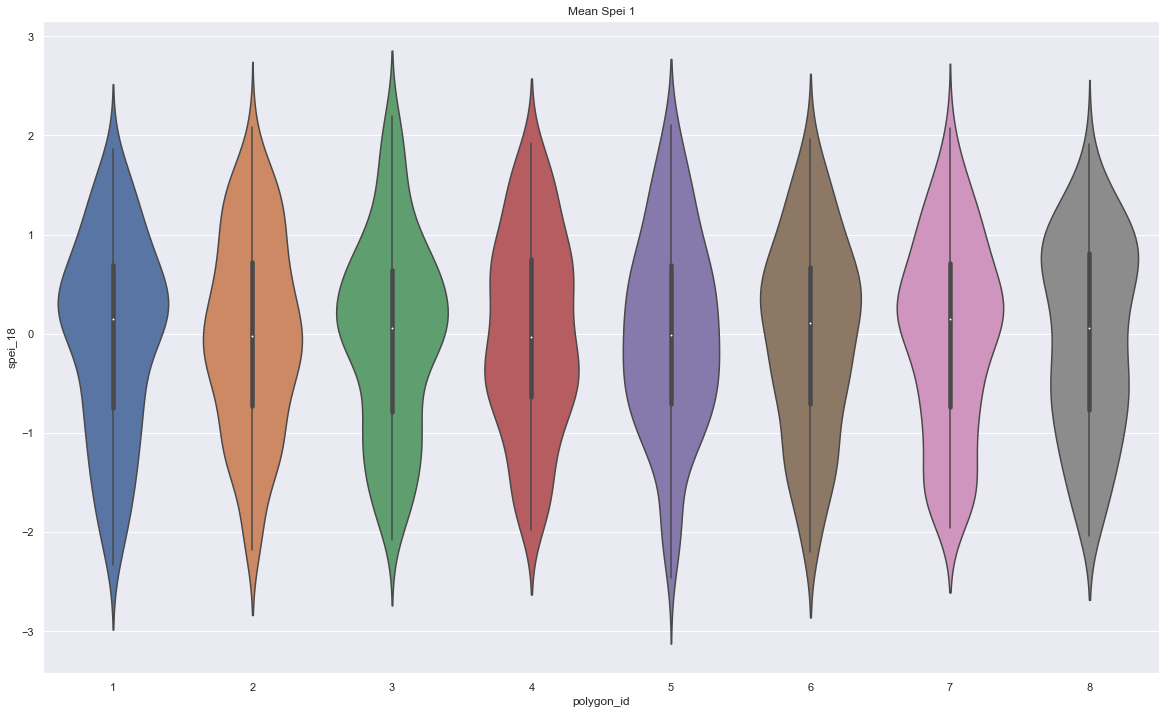

In [290]:
sns.violinplot(spei, x='polygon_id', y='spei_18').set(title="Mean Spei 1")

In [ ]:
spei[spei.polygon_id]

spei = pd.read_csv('../../data/interim/2001-2023_spei_per_polygon_50km_climate_resolution.csv', index_col=0)